In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import util.io

import torch
import torch.optim as optim
from torchvision.transforms import Compose

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

from dpt.models import DPTDepthModel
from dpt.midas_net import MidasNet_large
from dpt.transforms import Resize, NormalizeImage, PrepareForNet
from data.InteriorNetDataset import InteriorNetDataset
from data.metrics import SILog, get_metrics
from util.gpu_config import get_batch_size

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device name: {torch.cuda.get_device_name(0) if device != "cpu" else "cpu"}')

device name: Tesla V100-SXM2-32GB


In [3]:
s, t = 0.4364, 0.4115

net_w = 640
net_h = 480

# k8s paths
k8s = True
k8s_repo = r'opt/repo/dynamic-inference'
k8s_pvc = r'christh9-pvc'

# path settings
input_path = 'input'
output_path = 'output_monodepth'
model_path = 'weights/dpt_hybrid_nyu-2ce69ec7.pt'
dataset_path = 'video_inference_common/resources'

if k8s:
    input_path = os.path.join(k8s_repo, input_path)
    output_path = os.path.join(k8s_repo, output_path)
    model_path = os.path.join(k8s_pvc, 'train-logs', 'finetune1.pt')
    dataset_path = os.path.join(k8s_repo, dataset_path)

os.chdir('/')

In [4]:
normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
transform = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet(),
    ]
)

In [5]:
class InteriorNetDPT(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DPTDepthModel(
                        path=model_path,
                        scale=s,
                        shift=t,
                        #     scale=0.000305,
                        #     shift=0.1378,
                        invert=True,
                        backbone="vitb_rn50_384",
                        non_negative=True,
                        enable_attention_hooks=False,
                     )
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['depth']
        yhat = self.model(x)
        loss = SILog(yhat, 1/y)
        self.log('train_loss', loss, on_epoch=True)
        
        metrics = get_metrics(yhat.detach(), 1/y.detach())
        self.log('absrel', metrics[0], on_epoch=True)
        self.log('delta_acc', metrics[1], on_epoch=True)
        self.log('mae', metrics[2], on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), 
                          lr=1e-5)

In [6]:
interiornet_dataset = InteriorNetDataset(dataset_path, transform=transform, subsample=True)
model = InteriorNetDPT()
model.to(device)

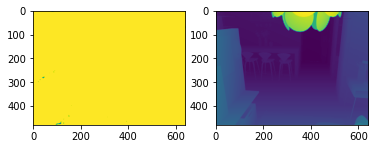

In [19]:
with torch.no_grad():
    for i in np.random.randint(0,1000,10):
        sample = interiornet_dataset[i]
        image, depth = torch.tensor(sample['image']).to(device), 1/sample['depth']
        out = model(image.unsqueeze(0)).squeeze(0).to('cpu')
              
        fig,axs = plt.subplots(1,2)
        axs[0].imshow((out - out.min()) / (out.max()-out.min()))
        axs[1].imshow(depth)
        plt.show()
        
        break